In [1]:
import numpy as np
import pandas as pd
import catboost
import time

from catboost import Pool, sum_models
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

In [2]:
FOLDS = 10
SEEDS = [0, 42, 888, 1042, 8888]
VERSION = round(time.time())

In [3]:
df_train_set = pd.read_csv('data/trainingValues.csv', index_col='id')
df_train_labels = pd.read_csv('data/trainingLabels.csv', index_col='id')

df_test = pd.read_csv('data/testValues.csv', index_col='id')

In [4]:
np.testing.assert_array_equal(df_train_set.index.values, df_train_labels.index.values)

In [5]:
joined_df = df_train_set.join(df_train_labels)

In [11]:
def clean_installer(df):

    df['installer'] = df['installer'].astype(str).str.lower()
    df['installer'].replace(
        to_replace=(
            'fini water', 'fin water', 'finn water', 'finwater', 'finwate'),
        value='finw', inplace=True)
    df['installer'].replace(to_replace=('jaica co'), value='jaica', inplace=True)
    df['installer'].replace(
        to_replace=(
            'district water department', 'district water depar', 'district council',
            'district counci', 'village council orpha','kibaha town council',
            'village council', 'coun', 'village counil', 'council',
            'mbulu district council', 'counc', 'village council .oda',
            'sangea district coun', 'songea district coun', 'villege council',
            'district  council', 'quick win project /council', 'mbozi district council',
            'village  council', 'municipal council', 'tabora municipal council',
            'wb / district council'),
        value='council', inplace=True)
    df['installer'].replace(
        to_replace=(
            'rc church', 'rc churc', 'rcchurch/cefa', 'irc', 'rc', 'rc ch', 'hw/rc',
            'rc church/central gover', 'kkkt church', 'pentecost church', 'roman church',
            'rc/mission', 'rc church/cefa', 'lutheran church', 'tag church',
            'free pentecoste church of tanz', 'rc c', 'church', 'rc cathoric',
            'morovian church', 'cefa/rc church', 'rc mission', 'anglican church',
            'church of disciples', 'anglikana church', 'cetral government /rc',
            'pentecostal church', 'cg/rc', 'rc missionary', 'sda church', 'methodist church', 'trc',
            'rc msufi', 'haidomu lutheran church', 'baptist church', 'rc church brother',
            'st magreth church', 'anglica church', 'global resource co', 'rc mi',
            'baptist church of tanzania', 'fpct church', 'rc njoro', 'rc .church',
            'rc mis', 'batist church', 'churc', 'dwe/anglican church','missi', 'mission',
            'ndanda missions', 'rc/mission', 'cvs miss', 'missionaries', 'hydom luthelani',
            'luthe', 'haydom lutheran hospital', 'lutheran', 'missio', 'germany missionary',
            'grail mission kiseki bar', 'missionary', 'heri mission', 'german missionsry',
            'wamissionari wa kikatoriki', 'neemia mission', 'wamisionari wa kikatoriki'),
        value='church', inplace=True)
    df['installer'].replace(
        to_replace=(
            'central government', 'gove', 'central govt', 'gover', 'cipro/government',
            'governme', 'adra /government', 'isf/government', 'adra/government',
            'government /tcrs', 'village govt', 'government', 'government /community',
            'concern /government', 'goverm', 'village government', 'cental government',
            'govern', 'cebtral government', 'government /sda', 'tcrs /government',
            'tanzania government', 'centra govt', 'colonial government', 'misri government',
            'government and community', 'cetral government /rc', 'concern/government',
            'government of misri', 'lwi &central government', 'governmen', 'government/tcrs', 'government /world vision',
            'centra government'),
        value='tanzanian government', inplace=True)
    df['installer'].replace(
        to_replace=(
            'world vission', 'world division', 'word divisio','world visiin'),
        value='world vision', inplace=True)
    df['installer'].replace(to_replace=('unicrf'), value='unicef', inplace=True)
    df['installer'].replace(
        to_replace=(
            'commu', 'olgilai village community', 'adra /community', 'adra/community',
            'rwe/ community', 'killflora /community', 'communit', 'taboma/community',
            'arab community', 'adra/ community', 'sekei village community', 'rwe/community',
            'arabs community', 'village community', 'government /community',
            'dads/village community', 'killflora/ community', 'mtuwasa and community',
            'rwe /community', 'ilwilo community', 'summit for water/community',
            'igolola community', 'ngiresi village community', 'rwe community',
            'african realief committe of ku', 'twesa /community', 'shelisheli commission',
            'twesa/ community', 'marumbo community', 'government and community',
            'community bank', 'kitiangare village community', 'oldadai village community',
            'twesa/community', 'tlc/community', 'maseka community', 'islamic community',
            'district community j', 'village water commission', 'village community members',
            'tcrs/village community', 'village water committee', 'comunity'),
        value='community', inplace=True)
    df['installer'].replace(
        to_replace=(
            'danid', 'danda','danida co', 'danny', 'daniad', 'dannida', 'danids'),
        value='danida', inplace=True)
    df['installer'].replace(
        to_replace=(
            'hesaws', 'huches', 'hesaw', 'hesawz', 'hesawq', 'hesewa'),
        value='hesawa', inplace=True)
    df['installer'].replace(
        to_replace=(
            'dwsp', 'kkkt _ konde and dwe', 'rwe/dwe', 'rwedwe', 'dwe/', 'dw', 'dwr',
            'dwe}', 'dwt', 'dwe /tassaf', 'dwe/ubalozi wa marekani', 'consultant and dwe',
            'dwe & lwi', 'ubalozi wa marekani /dwe', 'dwe&', 'dwe/tassaf', 'dw$',
            'dw e', 'tcrs/dwe', 'dw#', 'dweb', 'tcrs /dwe', 'water aid/dwe', 'dww'),
        value='dwe', inplace=True)
    df['installer'].replace(
        to_replace=(
            'africa muslim', 'muslimu society(shia)', 'africa muslim agenc',
            'african muslims age', 'muslimehefen international','islamic',
            'the isla', 'islamic agency tanzania',  'islam', 'nyabibuye islamic center'),
        value='muslims', inplace=True)
    df['installer'].replace(
        to_replace=(
            'british colonial government', 'british government', 'britain'),
        value='british', inplace=True)
    df['installer'].replace(
        to_replace=(
            'tcrs/tlc', 'tcrs /care', 'cipro/care/tcrs', 'tcrs kibondo', 'tcrs.tlc',
            'tcrs /twesa', 'tassaf /tcrs', 'tcrs/care', 'tcrs twesa', 'rwe/tcrs',
            'tcrs/twesa', 'tassaf/ tcrs', 'tcrs/ tassaf', 'tcrs/ twesa', 'tcrs a',
            'tassaf/tcrs'),
        value='tcrs', inplace=True)
    df['installer'].replace(
        to_replace=(
            'kkkt-dioces ya pare', 'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme',
            'kkkt kilinga', 'kkkt canal', 'kkkt katiti juu', 'kkkt mareu'),
        value='kkkt', inplace=True)
    df['installer'].replace(to_replace=('norad/'), value='norad', inplace=True)
    df['installer'].replace( to_replace=('tasaf/dmdd', 'dmdd/solider'),
        value='dmdd', inplace=True)
    df['installer'].replace(
        to_replace=('cjejow construction', 'cjej0'), value='cjejow', inplace=True)
    df['installer'].replace(
        to_replace=(
            'china henan constuction', 'china henan contractor', 'china co.', 'chinese'),
        value='china', inplace=True)
    df['installer'].replace(
        to_replace=(
            'local contract', 'local technician', 'local', 'local  technician',
            'locall technician', 'local te', 'local technitian', 'local technical tec',
            'local fundi', 'local technical', 'localtechnician', 'village local contractor',
            'local l technician'),
        value='local', inplace=True)
    df['installer'].replace(
        to_replace=(
            'oikos e .africa', 'oikos e.africa', 'africa amini alama',
            'africa islamic agency tanzania', 'africare', 'african development foundation',
            'oikos e. africa', 'oikos e.afrika', 'afroz ismail', 'africa', 'farm-africa',
            'oikos e africa', 'farm africa', 'africaone', 'tina/africare', 'africaone ltd',
            'african reflections foundation', 'africa m'),
        value='africa', inplace=True)
    df['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_installer_cnt = df.groupby('installer')['installer'].count()
    other_list = df_installer_cnt[df_installer_cnt<71].index.tolist()
    df['installer'].replace(to_replace=other_list, value='other', inplace=True)

In [12]:
def clean_funder(df):
    
    df['funder'] = df['funder'].astype(str).str.lower()
    df['funder'].replace(
        to_replace=(
            'kkkt_makwale', 'kkkt-dioces ya pare', 'world vision/ kkkt', 'kkkt church',
            'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme', 'kkkt canal', 'kkkt usa',
            'kkkt mareu'),
        value='kkkt', inplace=True)
    df['funder'].replace(
        to_replace=(
            'government of tanzania', 'norad /government', 'government/ community',
            'cipro/government', 'isf/government', 'finidagermantanzania govt',
            'government /tassaf', 'finida german tanzania govt', 'village government',
            'tcrs /government', 'village govt', 'government/ world bank',
            'danida /government', 'dhv/gove', 'concern /govern', 'vgovernment',
            'lwi & central government', 'government /sda', 'koica and tanzania government',
            'world bank/government', 'colonial government', 'misri government',
            'government and community', 'concern/governm', 'government of misri',
            'government/tassaf', 'government/school', 'government/tcrs', 'unhcr/government',
            'government /world vision', 'norad/government'),
        value='government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'british colonial government', 'japan government', 'china government',
            'finland government', 'belgian government', 'italy government',
            'irish government', 'egypt government', 'iran gover', 'swedish', 'finland'),
        value='foreign government', inplace=True)
    df['funder'].replace(
        to_replace=(
            'rc church', 'anglican church', 'rc churc', 'rc ch', 'rcchurch/cefa',
            'irc', 'rc', 'churc', 'hw/rc', 'rc church/centr', 'pentecosta church',
            'roman church', 'rc/mission', "ju-sarang church' and bugango",
            'lutheran church', 'roman cathoric church', 'tag church ub', 'aic church',
            'free pentecoste church of tanz', 'tag church', 'fpct church', 'rc cathoric',
            'baptist church', 'morovian church', 'cefa/rcchurch', 'rc mission',
            'bukwang church saints', 'agt church', 'church of disciples', 'rc mofu',
            "gil cafe'church'", 'pentecostal church', 'bukwang church saint',
            'eung am methodist church', 'rc/dwe', 'cg/rc', 'eung-am methodist church',
            'rc missionary', 'sda church', 'methodist church', 'rc msufi',
            'haidomu lutheran church', 'nazareth church', 'st magreth church',
            'agape churc', 'rc missi', 'rc mi', 'rc njoro', 'world vision/rc church',
            'pag church', 'batist church', 'full gospel church', 'nazalet church',
            'dwe/anglican church', 'missi', 'mission', 'missionaries', 'cpps mission',
            'cvs miss', 'grail mission kiseki bar', 'shelisheli commission', 'missionary',
            'heri mission', 'german missionary', 'wamissionari wa kikatoriki',
            'rc missionary', 'germany missionary', 'missio', 'neemia mission', 'rc missi',
            'hydom luthelani', 'luthe', 'lutheran church',  'haydom lutheran hospital',
            'village council/ haydom luther', 'lutheran', 'haidomu lutheran church',
            'resolute golden pride project', 'resolute mininggolden pride',
            'germany cristians'),
        value='church', inplace=True)
    df['funder'].replace(
        to_replace=(
            'olgilai village community', 'commu', 'community', 'arab community',
            'sekei village community', 'arabs community', 'village community',
            'mtuwasa and community', 'ilwilo community', 'igolola community',
            'ngiresi village community', 'marumbo community', 'village communi',
            'comune di roma', 'comunity construction fund', 'community bank',
            "oak'zion' and bugango b' commu", 'kitiangare village community',
            'oldadai village community', 'tlc/community', 'maseka community',
            'islamic community',  'tcrs/village community', 'buluga subvillage community',
            'okutu village community'),
        value='community', inplace=True)
    df['funder'].replace(
        to_replace=(
            'council', 'wb / district council', 'cdtfdistrict council',
            'sangea district council', 'mheza distric counc', 'kyela council',
            'kibaha town council', 'swidish', 'mbozi district council', 
            'village council/ rose kawala',  'songea municipal counci',
            'quick win project /council', 'village council', 'villege council',
            'tabora municipal council', 'kilindi district co', 'kigoma municipal council',
            'district council', 'municipal council', 'district medical',
            'sengerema district council', 'town council', 'mkinga  distric cou',
            'songea district council', 'district rural project', 'mkinga distric coun',
            'dadis'),
        value='district', inplace=True)
    df['funder'].replace(
        to_replace=(
            'tcrs.tlc', 'tcrs /care', 'tcrst', 'cipro/care/tcrs', 'tcrs/care', 'tcrs kibondo'),
        value='tcrs', inplace=True)
    df['funder'].replace(
        to_replace=(
            'fini water', 'finw', 'fin water', 'finn water', 'finwater'),
        value='fini', inplace=True)
    df['funder'].replace(
        to_replace=(
            'islamic', 'the isla', 'islamic found', 'islamic agency tanzania',
            'islam', 'muislam', 'the islamic', 'nyabibuye islamic center', 'islamic society', 'african muslim agency',
            'muslims', 'answeer muslim grou', 'muslimu society(shia)',
            'unicef/african muslim agency', 'muslim world', 'muslimehefen international',
            'shear muslim', 'muslim society'),
        value='islam', inplace=True)
    df['funder'].replace(
        to_replace=('danida', 'ms-danish', 'unhcr/danida', 'tassaf/ danida'),
        value='danida', inplace=True)
    df['funder'].replace(
        to_replace=(
            'hesawa', 'hesawz', 'hesaw', 'hhesawa', 'hesawwa', 'hesawza', 'hesswa',
            'hesawa and concern world wide'),
        value='hesawa', inplace=True)
    df['funder'].replace(
        to_replace=('world vision/adra', 'game division', 'worldvision'),
        value='world vision', inplace=True)
    df['funder'].replace(
        to_replace=(
            'germany republi', 'a/co germany', 'aco/germany', 'bingo foundation germany',
            'africa project ev germany', 'tree ways german'),
        value='germany', inplace=True)
    df['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
    df_funder_cnt = df.groupby('funder')['funder'].count()
    other_list = df_funder_cnt[df_funder_cnt<98].index.tolist()
    df['funder'].replace(to_replace=other_list, value='other', inplace=True)    

In [13]:
def get_medians_df(df):
    
    df_geo = df.groupby(['region_code'])[['latitude', 'longitude']].median()
    df_subvillage = df.groupby(['region_code'])['subvillage'].agg(pd.Series.mode)
    df_scheme = df.groupby(['region'])['scheme_name'].agg(pd.Series.mode)
    return df_geo, df_subvillage, df_scheme
    
    
def geo_restore(df, df_geo):
    
    def geo_update(row, df_geo):
        row['longitude'] = df_geo.loc[row['region_code']]['longitude']
        row['latitude'] = df_geo.loc[row['region_code']]['latitude']
        return row

    df.loc[df['longitude']==0, ['longitude', 'latitude']] = \
        df[df['longitude']==0].apply(
            geo_update, df_geo=df_geo, axis=1)[['longitude', 'latitude']]
    
    
def scheme_restore(df, df_scheme):
    
    def scheme_update(row, df_scheme):
        row['scheme_name'] = df_scheme[row['region']]
        return row

    df.loc[df['scheme_name'].isnull(), ['scheme_name']] = \
        df[df['scheme_name'].isnull()].apply(
            scheme_update, df_scheme=df_scheme, axis=1)[['scheme_name']]
    
    
def subvillage_restore(df, df_subvillage):

    def subvillage_update(row, df_subvillage):
        row['subvillage'] = df_subvillage[row['region_code']]
        return row

    df.loc[df['subvillage'].isnull(), ['subvillage']] = \
        df[df['subvillage'].isnull()].apply(
            subvillage_update, df_subvillage=df_subvillage, axis=1)[['subvillage']]
    
    
def get_medians(df):
    
    df_pm_median = df['public_meeting'].median()
    df_permit_median = df['permit'].median()
    return df_pm_median, df_permit_median
    
    
def fill_na(df, df_pm_median, df_permit_median):
    
    df.loc[df['public_meeting'].isnull(), 'public_meeting'] = df_pm_median
    df.loc[df['permit'].isnull(), 'permit'] = df_permit_median
    
    
def create_na_features(df):    
    
    na_cols = ['subvillage', 'public_meeting', 'scheme_name', 'permit']
    for c in na_cols:
        df[f'c_na'] = df[c].isnull()  


In [14]:
def drop(df):
    
    df.drop([
        'scheme_management', 'quantity_group', 'water_quality', 'region_code', 'payment_type',
        'extraction_type', 'waterpoint_type_group', 'date_recorded', 'recorded_by'],
        axis=1, inplace=True)


In [15]:
df_train = df_train_set.join(df_train_labels)
clean_installer(df_train)
clean_funder(df_train)
df_geo, df_subvillage, df_scheme = get_medians_df(df_train)
geo_restore(df_train, df_geo)
subvillage_restore(df_train, df_subvillage)
scheme_restore(df_train, df_scheme)
create_na_features(df_train)
df_pm_median, df_permit_median = get_medians(df_train)
fill_na(df_train, df_pm_median, df_permit_median)
drop(df_train)

clean_installer(df_test)
clean_funder(df_test)
geo_restore(df_test, df_geo)
subvillage_restore(df_test, df_subvillage)
scheme_restore(df_test, df_scheme)
create_na_features(df_test)
fill_na(df_test, df_pm_median, df_permit_median)
drop(df_test)

In [16]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        max_ctr_complexity=5,
        task_type='GPU',
        iterations=10000,
        eval_metric='AUC',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=1000,
        plot=False,
        use_best_model=True)

In [17]:
num_cols = [
    'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
    'district_code', 'population'
]
cat_features = [x for x in df_train.columns if x not in num_cols and x!='status_group']
df_train[cat_features] = df_train[cat_features].astype('category')
df_test[cat_features] = df_test[cat_features].astype('category')

In [18]:
def classification_rate(y, y_pred):
    return np.sum(y==y_pred)/len(y)

In [19]:
def get_oof(n_folds, x_train, y, x_test, cat_features, seeds):
    
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]  
        
    oof_train = np.zeros((len(seeds), ntrain, 3))
    oof_test = np.zeros((ntest, 3))
    oof_test_skf = np.empty((len(seeds), n_folds, ntest, 3))
    
    test_pool = Pool(data=x_test, cat_features=cat_features) 
    models = {}
    
    for iseed, seed in enumerate(seeds):
        kf = StratifiedKFold(
            n_splits=n_folds,
            shuffle=True,
            random_state=seed)          
        for i, (train_index, test_index) in enumerate(kf.split(x_train, y)):
            print(f'\nSeed {seed}, Fold {i}')
            x_tr = x_train.iloc[train_index, :]
            y_tr = y[train_index]
            x_te = x_train.iloc[test_index, :]
            y_te = y[test_index]
            train_pool = Pool(data=x_tr, label=y_tr, cat_features=cat_features)
            valid_pool = Pool(data=x_te, label=y_te, cat_features=cat_features) 

            model = fit_model(
                train_pool, valid_pool,
                loss_function='MultiClass',
                random_seed=seed
            )
            oof_train[iseed, test_index, :] = model.predict_proba(x_te)
            oof_test_skf[iseed, i, :, :] = model.predict_proba(x_test)
            models[(seed, i)] = model
            model.save_model(
                f"cb_{seed}_{i}_{VERSION}.cbm",
                format="cbm", export_parameters=None, pool=None)

    oof_test[:, :] = oof_test_skf.mean(axis=1).mean(axis=0)
    oof_train = oof_train.mean(axis=0)
    return oof_train, oof_test, models

In [20]:
y_train, X_train = df_train['status_group'], df_train.drop(['status_group'], axis=1)

oof_train, oof_test, models = get_oof(
    n_folds=FOLDS,
    x_train=X_train,
    y=y_train.values,
    x_test=df_test,
    cat_features=cat_features,
    seeds=SEEDS)


Seed 0, Fold 0
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6235972	best: 0.6235972 (0)	total: 201ms	remaining: 33m 25s
1000:	test: 0.9001534	best: 0.9001613 (999)	total: 58.8s	remaining: 8m 48s
2000:	test: 0.9050235	best: 0.9050235 (2000)	total: 1m 43s	remaining: 6m 53s
3000:	test: 0.9075502	best: 0.9076182 (2890)	total: 2m 30s	remaining: 5m 50s
4000:	test: 0.9082286	best: 0.9083542 (3937)	total: 3m 17s	remaining: 4m 55s
5000:	test: 0.9086149	best: 0.9086651 (4966)	total: 4m 4s	remaining: 4m 4s
6000:	test: 0.9091607	best: 0.9091607 (6000)	total: 4m 51s	remaining: 3m 14s
7000:	test: 0.9087165	best: 0.9093559 (6571)	total: 5m 38s	remaining: 2m 24s
bestTest = 0.9093559491
bestIteration = 6571
Shrink model to first 6572 iterations.

Seed 0, Fold 1
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6306776	best: 0.6306776 (0)	total: 48ms	remaining: 8m
1000:	test: 0.9086931	best: 0.9087435 (982)	total: 45.2s	remaining: 6m 46s
2000:	test: 0.9118026	best: 0.9118289 (1894)	total: 1m 25s	remaining: 5m 43s
3000:	test: 0.9127597	best: 0.9128221 (2941)	total: 2m 6s	remaining: 4m 55s
4000:	test: 0.9129919	best: 0.9131274 (3760)	total: 2m 48s	remaining: 4m 13s
bestTest = 0.9131273564
bestIteration = 3760
Shrink model to first 3761 iterations.

Seed 0, Fold 2
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6284235	best: 0.6284235 (0)	total: 88.7ms	remaining: 14m 46s
1000:	test: 0.9130946	best: 0.9130985 (998)	total: 41.8s	remaining: 6m 16s
2000:	test: 0.9172144	best: 0.9172144 (2000)	total: 1m 22s	remaining: 5m 30s
3000:	test: 0.9184039	best: 0.9184334 (2961)	total: 2m 4s	remaining: 4m 50s
4000:	test: 0.9187064	best: 0.9188868 (3858)	total: 2m 46s	remaining: 4m 10s
5000:	test: 0.9192668	best: 0.9194760 (4899)	total: 3m 27s	remaining: 3m 27s
bestTest = 0.9194759814
bestIteration = 4899
Shrink model to first 4900 iterations.

Seed 0, Fold 3
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6274893	best: 0.6274893 (0)	total: 87.1ms	remaining: 14m 30s
1000:	test: 0.9076462	best: 0.9076762 (997)	total: 40.5s	remaining: 6m 3s
2000:	test: 0.9114720	best: 0.9114932 (1994)	total: 1m 20s	remaining: 5m 22s
3000:	test: 0.9121710	best: 0.9122433 (2981)	total: 2m 3s	remaining: 4m 49s
bestTest = 0.9122432856
bestIteration = 2981
Shrink model to first 2982 iterations.

Seed 0, Fold 4
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6169818	best: 0.6169818 (0)	total: 64.1ms	remaining: 10m 40s
1000:	test: 0.9015505	best: 0.9015712 (998)	total: 44.1s	remaining: 6m 36s
2000:	test: 0.9063824	best: 0.9063846 (1997)	total: 1m 26s	remaining: 5m 45s
3000:	test: 0.9077482	best: 0.9077637 (2990)	total: 2m 9s	remaining: 5m 1s
4000:	test: 0.9087971	best: 0.9088869 (3968)	total: 2m 51s	remaining: 4m 17s
5000:	test: 0.9094420	best: 0.9097294 (4798)	total: 3m 34s	remaining: 3m 34s
bestTest = 0.909729366
bestIteration = 4798
Shrink model to first 4799 iterations.

Seed 0, Fold 5
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6311703	best: 0.6311703 (0)	total: 70.2ms	remaining: 11m 42s
1000:	test: 0.9010178	best: 0.9010239 (999)	total: 43.1s	remaining: 6m 27s
2000:	test: 0.9053349	best: 0.9054553 (1973)	total: 1m 25s	remaining: 5m 40s
3000:	test: 0.9075414	best: 0.9075511 (2999)	total: 2m 5s	remaining: 4m 53s
4000:	test: 0.9085812	best: 0.9086628 (3946)	total: 2m 46s	remaining: 4m 9s
5000:	test: 0.9092551	best: 0.9093529 (4930)	total: 3m 27s	remaining: 3m 27s
6000:	test: 0.9093943	best: 0.9095914 (5864)	total: 4m 8s	remaining: 2m 45s
bestTest = 0.909591395
bestIteration = 5864
Shrink model to first 5865 iterations.

Seed 0, Fold 6
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6305888	best: 0.6305888 (0)	total: 175ms	remaining: 29m 10s
1000:	test: 0.9056213	best: 0.9056213 (1000)	total: 40.8s	remaining: 6m 6s
2000:	test: 0.9114977	best: 0.9115206 (1996)	total: 1m 21s	remaining: 5m 25s
3000:	test: 0.9130029	best: 0.9130950 (2976)	total: 2m 2s	remaining: 4m 44s
bestTest = 0.9135751057
bestIteration = 3413
Shrink model to first 3414 iterations.

Seed 0, Fold 7
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6223396	best: 0.6223396 (0)	total: 52.8ms	remaining: 8m 47s
1000:	test: 0.9046584	best: 0.9046584 (1000)	total: 40.5s	remaining: 6m 3s
2000:	test: 0.9121778	best: 0.9122147 (1998)	total: 1m 20s	remaining: 5m 22s
3000:	test: 0.9146097	best: 0.9146097 (3000)	total: 2m 1s	remaining: 4m 43s
4000:	test: 0.9160483	best: 0.9160511 (3998)	total: 2m 43s	remaining: 4m 4s
5000:	test: 0.9169141	best: 0.9169684 (4866)	total: 3m 26s	remaining: 3m 26s
6000:	test: 0.9168733	best: 0.9171467 (5579)	total: 4m 9s	remaining: 2m 46s
bestTest = 0.9171467098
bestIteration = 5579
Shrink model to first 5580 iterations.

Seed 0, Fold 8
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6250448	best: 0.6250448 (0)	total: 114ms	remaining: 19m
1000:	test: 0.9118851	best: 0.9118904 (999)	total: 43s	remaining: 6m 26s
2000:	test: 0.9160235	best: 0.9161143 (1956)	total: 1m 26s	remaining: 5m 45s
3000:	test: 0.9171276	best: 0.9171651 (2982)	total: 2m 10s	remaining: 5m 5s
4000:	test: 0.9174877	best: 0.9175358 (3966)	total: 2m 52s	remaining: 4m 19s
5000:	test: 0.9175581	best: 0.9178559 (4749)	total: 3m 36s	remaining: 3m 36s
bestTest = 0.9178558708
bestIteration = 4749
Shrink model to first 4750 iterations.

Seed 0, Fold 9
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6206222	best: 0.6206222 (0)	total: 47.6ms	remaining: 7m 56s
1000:	test: 0.9082835	best: 0.9083143 (997)	total: 41s	remaining: 6m 8s
2000:	test: 0.9126562	best: 0.9126600 (1998)	total: 1m 21s	remaining: 5m 26s
3000:	test: 0.9138458	best: 0.9139643 (2800)	total: 2m 3s	remaining: 4m 47s
4000:	test: 0.9145531	best: 0.9145541 (3999)	total: 2m 49s	remaining: 4m 13s
bestTest = 0.9147753065
bestIteration = 4201
Shrink model to first 4202 iterations.

Seed 42, Fold 0
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6348975	best: 0.6348975 (0)	total: 63.1ms	remaining: 10m 30s
1000:	test: 0.9199731	best: 0.9199731 (1000)	total: 43.5s	remaining: 6m 30s
2000:	test: 0.9240995	best: 0.9241109 (1999)	total: 1m 23s	remaining: 5m 33s
3000:	test: 0.9247992	best: 0.9249507 (2731)	total: 2m 5s	remaining: 4m 51s
bestTest = 0.9251454846
bestIteration = 3376
Shrink model to first 3377 iterations.

Seed 42, Fold 1
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6220207	best: 0.6220207 (0)	total: 62ms	remaining: 10m 20s
1000:	test: 0.9044410	best: 0.9044665 (991)	total: 41.7s	remaining: 6m 15s
2000:	test: 0.9107536	best: 0.9107702 (1997)	total: 1m 23s	remaining: 5m 32s
3000:	test: 0.9129377	best: 0.9129461 (2999)	total: 2m 5s	remaining: 4m 52s
4000:	test: 0.9139925	best: 0.9140037 (3999)	total: 2m 48s	remaining: 4m 12s
bestTest = 0.9143581451
bestIteration = 4096
Shrink model to first 4097 iterations.

Seed 42, Fold 2
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6338983	best: 0.6338983 (0)	total: 36.6ms	remaining: 6m 5s
1000:	test: 0.9085354	best: 0.9085360 (998)	total: 43s	remaining: 6m 26s
2000:	test: 0.9128248	best: 0.9128447 (1996)	total: 1m 20s	remaining: 5m 22s
3000:	test: 0.9143208	best: 0.9143348 (2996)	total: 2m 9s	remaining: 5m 1s
4000:	test: 0.9148026	best: 0.9149273 (3731)	total: 2m 49s	remaining: 4m 13s
bestTest = 0.9149273294
bestIteration = 3731
Shrink model to first 3732 iterations.

Seed 42, Fold 3
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6233488	best: 0.6233488 (0)	total: 38.9ms	remaining: 6m 29s
1000:	test: 0.9066652	best: 0.9066652 (1000)	total: 42.8s	remaining: 6m 24s
2000:	test: 0.9118548	best: 0.9118638 (1995)	total: 1m 22s	remaining: 5m 30s
3000:	test: 0.9136094	best: 0.9136482 (2984)	total: 2m 8s	remaining: 4m 59s
4000:	test: 0.9149600	best: 0.9150755 (3967)	total: 2m 47s	remaining: 4m 11s
5000:	test: 0.9157094	best: 0.9157314 (4984)	total: 3m 30s	remaining: 3m 30s
6000:	test: 0.9161388	best: 0.9163879 (5768)	total: 4m 14s	remaining: 2m 49s
bestTest = 0.9163879142
bestIteration = 5768
Shrink model to first 5769 iterations.

Seed 42, Fold 4
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6241453	best: 0.6241453 (0)	total: 40ms	remaining: 6m 39s
1000:	test: 0.9041768	best: 0.9042088 (994)	total: 39.9s	remaining: 5m 58s
2000:	test: 0.9080171	best: 0.9080214 (1930)	total: 1m 24s	remaining: 5m 37s
3000:	test: 0.9095536	best: 0.9095815 (2995)	total: 2m 6s	remaining: 4m 55s
4000:	test: 0.9100546	best: 0.9100546 (4000)	total: 2m 56s	remaining: 4m 24s
5000:	test: 0.9104529	best: 0.9105173 (4955)	total: 3m 48s	remaining: 3m 48s
bestTest = 0.9105173368
bestIteration = 4955
Shrink model to first 4956 iterations.

Seed 42, Fold 5
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6189409	best: 0.6189409 (0)	total: 52.6ms	remaining: 8m 45s
1000:	test: 0.9011858	best: 0.9011858 (1000)	total: 43s	remaining: 6m 26s
2000:	test: 0.9073807	best: 0.9073984 (1998)	total: 1m 22s	remaining: 5m 28s
3000:	test: 0.9103929	best: 0.9104166 (2975)	total: 1m 59s	remaining: 4m 39s
4000:	test: 0.9123315	best: 0.9123836 (3992)	total: 2m 41s	remaining: 4m 2s
5000:	test: 0.9125980	best: 0.9126513 (4908)	total: 3m 22s	remaining: 3m 22s
6000:	test: 0.9129421	best: 0.9130381 (5542)	total: 4m 4s	remaining: 2m 42s
bestTest = 0.9130380622
bestIteration = 5542
Shrink model to first 5543 iterations.

Seed 42, Fold 6
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6190010	best: 0.6190010 (0)	total: 42.7ms	remaining: 7m 6s
1000:	test: 0.8996202	best: 0.8996202 (1000)	total: 41.8s	remaining: 6m 15s
2000:	test: 0.9054776	best: 0.9054776 (2000)	total: 1m 21s	remaining: 5m 26s
3000:	test: 0.9073820	best: 0.9077636 (2836)	total: 1m 59s	remaining: 4m 38s
4000:	test: 0.9084731	best: 0.9084957 (3997)	total: 2m 38s	remaining: 3m 58s
bestTest = 0.908495713
bestIteration = 3997
Shrink model to first 3998 iterations.

Seed 42, Fold 7
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6254051	best: 0.6254051 (0)	total: 37ms	remaining: 6m 9s
1000:	test: 0.9083262	best: 0.9083313 (998)	total: 37.7s	remaining: 5m 38s
2000:	test: 0.9122926	best: 0.9123089 (1823)	total: 1m 16s	remaining: 5m 7s
3000:	test: 0.9133028	best: 0.9133719 (2994)	total: 1m 53s	remaining: 4m 25s
bestTest = 0.9135686213
bestIteration = 3112
Shrink model to first 3113 iterations.

Seed 42, Fold 8
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6151093	best: 0.6151093 (0)	total: 38.4ms	remaining: 6m 23s
1000:	test: 0.8996573	best: 0.8996573 (1000)	total: 45.3s	remaining: 6m 46s
2000:	test: 0.9049652	best: 0.9050024 (1977)	total: 1m 25s	remaining: 5m 43s
3000:	test: 0.9072274	best: 0.9072747 (2970)	total: 2m 6s	remaining: 4m 55s
4000:	test: 0.9080122	best: 0.9080823 (3916)	total: 2m 48s	remaining: 4m 11s
5000:	test: 0.9083237	best: 0.9085202 (4614)	total: 3m 27s	remaining: 3m 27s
bestTest = 0.9085201883
bestIteration = 4614
Shrink model to first 4615 iterations.

Seed 42, Fold 9
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6320445	best: 0.6320445 (0)	total: 40.3ms	remaining: 6m 42s
1000:	test: 0.9054230	best: 0.9054230 (1000)	total: 39.2s	remaining: 5m 52s
2000:	test: 0.9106032	best: 0.9106213 (1996)	total: 1m 18s	remaining: 5m 12s
3000:	test: 0.9120023	best: 0.9120603 (2930)	total: 1m 58s	remaining: 4m 35s
4000:	test: 0.9130444	best: 0.9132066 (3917)	total: 2m 40s	remaining: 4m
5000:	test: 0.9132935	best: 0.9134737 (4786)	total: 3m 19s	remaining: 3m 19s
bestTest = 0.9136801453
bestIteration = 5489
Shrink model to first 5490 iterations.

Seed 888, Fold 0
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6220444	best: 0.6220444 (0)	total: 57ms	remaining: 9m 30s
1000:	test: 0.9015117	best: 0.9015117 (1000)	total: 39.5s	remaining: 5m 54s
2000:	test: 0.9079350	best: 0.9079350 (2000)	total: 1m 19s	remaining: 5m 18s
3000:	test: 0.9099237	best: 0.9100040 (2770)	total: 1m 59s	remaining: 4m 38s
4000:	test: 0.9109789	best: 0.9110295 (3896)	total: 2m 39s	remaining: 3m 59s
5000:	test: 0.9113909	best: 0.9114595 (4797)	total: 3m 19s	remaining: 3m 19s
bestTest = 0.9114617757
bestIteration = 5035
Shrink model to first 5036 iterations.

Seed 888, Fold 1
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6188945	best: 0.6188945 (0)	total: 58.3ms	remaining: 9m 43s
1000:	test: 0.9032041	best: 0.9032180 (993)	total: 39.5s	remaining: 5m 55s
2000:	test: 0.9080160	best: 0.9080300 (1998)	total: 1m 18s	remaining: 5m 15s
3000:	test: 0.9095357	best: 0.9095537 (2998)	total: 1m 58s	remaining: 4m 37s
bestTest = 0.9096970405
bestIteration = 3032
Shrink model to first 3033 iterations.

Seed 888, Fold 2
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6201630	best: 0.6201630 (0)	total: 109ms	remaining: 18m 7s
1000:	test: 0.9085154	best: 0.9085166 (998)	total: 39.3s	remaining: 5m 53s
2000:	test: 0.9123349	best: 0.9123851 (1989)	total: 1m 19s	remaining: 5m 17s
3000:	test: 0.9134873	best: 0.9134873 (3000)	total: 1m 59s	remaining: 4m 39s
4000:	test: 0.9139195	best: 0.9140593 (3920)	total: 2m 40s	remaining: 4m 1s
bestTest = 0.9141367858
bestIteration = 4153
Shrink model to first 4154 iterations.

Seed 888, Fold 3
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6346521	best: 0.6346521 (0)	total: 65.5ms	remaining: 10m 55s
1000:	test: 0.9076191	best: 0.9076341 (996)	total: 44.4s	remaining: 6m 39s
2000:	test: 0.9125798	best: 0.9126670 (1973)	total: 1m 28s	remaining: 5m 54s
3000:	test: 0.9131889	best: 0.9133677 (2879)	total: 2m 13s	remaining: 5m 11s
4000:	test: 0.9140960	best: 0.9141020 (3999)	total: 2m 58s	remaining: 4m 27s
5000:	test: 0.9146187	best: 0.9147222 (4957)	total: 3m 43s	remaining: 3m 43s
bestTest = 0.9147221557
bestIteration = 4957
Shrink model to first 4958 iterations.

Seed 888, Fold 4
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6240637	best: 0.6240637 (0)	total: 68.3ms	remaining: 11m 23s
1000:	test: 0.9104934	best: 0.9104934 (1000)	total: 44.6s	remaining: 6m 40s
2000:	test: 0.9150850	best: 0.9150850 (2000)	total: 1m 27s	remaining: 5m 51s
3000:	test: 0.9169972	best: 0.9170775 (2972)	total: 2m 10s	remaining: 5m 3s
4000:	test: 0.9177610	best: 0.9177977 (3677)	total: 2m 52s	remaining: 4m 18s
bestTest = 0.9180237892
bestIteration = 4227
Shrink model to first 4228 iterations.

Seed 888, Fold 5
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6236824	best: 0.6236824 (0)	total: 64.5ms	remaining: 10m 45s
1000:	test: 0.9083978	best: 0.9083978 (1000)	total: 42.3s	remaining: 6m 19s
2000:	test: 0.9124808	best: 0.9124808 (2000)	total: 1m 24s	remaining: 5m 36s
3000:	test: 0.9138844	best: 0.9139836 (2886)	total: 2m 6s	remaining: 4m 54s
bestTest = 0.9140263712
bestIteration = 3472
Shrink model to first 3473 iterations.

Seed 888, Fold 6
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6267509	best: 0.6267509 (0)	total: 62.4ms	remaining: 10m 23s
1000:	test: 0.9012780	best: 0.9013284 (985)	total: 42.3s	remaining: 6m 20s
2000:	test: 0.9046205	best: 0.9046205 (2000)	total: 1m 24s	remaining: 5m 36s
3000:	test: 0.9056317	best: 0.9057823 (2834)	total: 2m 6s	remaining: 4m 54s
bestTest = 0.9057822564
bestIteration = 2834
Shrink model to first 2835 iterations.

Seed 888, Fold 7
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6282194	best: 0.6282194 (0)	total: 45.5ms	remaining: 7m 34s
1000:	test: 0.9074603	best: 0.9074626 (999)	total: 45.1s	remaining: 6m 45s
2000:	test: 0.9124929	best: 0.9125233 (1992)	total: 1m 29s	remaining: 5m 56s
3000:	test: 0.9147752	best: 0.9148169 (2993)	total: 2m 13s	remaining: 5m 11s
4000:	test: 0.9160016	best: 0.9160130 (3989)	total: 2m 58s	remaining: 4m 27s
5000:	test: 0.9162657	best: 0.9163873 (4771)	total: 3m 43s	remaining: 3m 43s
bestTest = 0.9163873154
bestIteration = 4771
Shrink model to first 4772 iterations.

Seed 888, Fold 8
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6212353	best: 0.6212353 (0)	total: 100ms	remaining: 16m 42s
1000:	test: 0.9045721	best: 0.9045732 (998)	total: 44.8s	remaining: 6m 43s
2000:	test: 0.9101980	best: 0.9102270 (1996)	total: 1m 45s	remaining: 7m 1s
3000:	test: 0.9128394	best: 0.9128394 (3000)	total: 2m 45s	remaining: 6m 24s
4000:	test: 0.9138987	best: 0.9139815 (3819)	total: 3m 30s	remaining: 5m 16s
5000:	test: 0.9144466	best: 0.9144701 (4996)	total: 4m 19s	remaining: 4m 19s
6000:	test: 0.9145847	best: 0.9147473 (5841)	total: 5m 8s	remaining: 3m 25s
bestTest = 0.9147472872
bestIteration = 5841
Shrink model to first 5842 iterations.

Seed 888, Fold 9
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6231529	best: 0.6231529 (0)	total: 46.1ms	remaining: 7m 41s
1000:	test: 0.9080667	best: 0.9080918 (998)	total: 46.9s	remaining: 7m 1s
2000:	test: 0.9135958	best: 0.9135958 (2000)	total: 1m 30s	remaining: 6m
3000:	test: 0.9158244	best: 0.9158776 (2992)	total: 2m 17s	remaining: 5m 19s
4000:	test: 0.9163130	best: 0.9163560 (3981)	total: 3m 1s	remaining: 4m 32s
bestTest = 0.9164704409
bestIteration = 4073
Shrink model to first 4074 iterations.

Seed 1042, Fold 0
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6259932	best: 0.6259932 (0)	total: 53.8ms	remaining: 8m 58s
1000:	test: 0.8997915	best: 0.8997979 (991)	total: 40.4s	remaining: 6m 3s
2000:	test: 0.9054756	best: 0.9055014 (1994)	total: 1m 24s	remaining: 5m 37s
3000:	test: 0.9074238	best: 0.9075175 (2983)	total: 2m 13s	remaining: 5m 12s
4000:	test: 0.9075490	best: 0.9075910 (3990)	total: 3m 5s	remaining: 4m 38s
bestTest = 0.9077283982
bestIteration = 4178
Shrink model to first 4179 iterations.

Seed 1042, Fold 1
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6275602	best: 0.6275602 (0)	total: 56.8ms	remaining: 9m 27s
1000:	test: 0.9036540	best: 0.9036905 (985)	total: 50.4s	remaining: 7m 33s
2000:	test: 0.9074675	best: 0.9075026 (1977)	total: 1m 47s	remaining: 7m 7s
3000:	test: 0.9086595	best: 0.9087170 (2942)	total: 2m 27s	remaining: 5m 43s
4000:	test: 0.9091123	best: 0.9094047 (3851)	total: 3m 7s	remaining: 4m 41s
bestTest = 0.9094046927
bestIteration = 3851
Shrink model to first 3852 iterations.

Seed 1042, Fold 2
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6257892	best: 0.6257892 (0)	total: 36.2ms	remaining: 6m 2s
1000:	test: 0.9128339	best: 0.9128339 (1000)	total: 40.3s	remaining: 6m 2s
2000:	test: 0.9182389	best: 0.9182461 (1996)	total: 1m 18s	remaining: 5m 12s
3000:	test: 0.9203177	best: 0.9203287 (2998)	total: 1m 56s	remaining: 4m 30s
4000:	test: 0.9209556	best: 0.9211159 (3510)	total: 2m 34s	remaining: 3m 51s
bestTest = 0.9211159055
bestIteration = 3510
Shrink model to first 3511 iterations.

Seed 1042, Fold 3
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6174409	best: 0.6174409 (0)	total: 38.2ms	remaining: 6m 22s
1000:	test: 0.9055327	best: 0.9055754 (997)	total: 38s	remaining: 5m 41s
2000:	test: 0.9092482	best: 0.9092970 (1979)	total: 1m 16s	remaining: 5m 7s
3000:	test: 0.9105696	best: 0.9105696 (3000)	total: 1m 56s	remaining: 4m 31s
bestTest = 0.9106587614
bestIteration = 3025
Shrink model to first 3026 iterations.

Seed 1042, Fold 4
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6251308	best: 0.6251308 (0)	total: 35.6ms	remaining: 5m 55s
1000:	test: 0.9092792	best: 0.9092792 (1000)	total: 37.7s	remaining: 5m 38s
2000:	test: 0.9130677	best: 0.9130752 (1997)	total: 1m 18s	remaining: 5m 11s
bestTest = 0.9134159159
bestIteration = 2198
Shrink model to first 2199 iterations.

Seed 1042, Fold 5
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6249465	best: 0.6249465 (0)	total: 56.1ms	remaining: 9m 21s
1000:	test: 0.9062414	best: 0.9062491 (995)	total: 43.4s	remaining: 6m 29s
2000:	test: 0.9115083	best: 0.9115083 (2000)	total: 1m 24s	remaining: 5m 38s
3000:	test: 0.9131194	best: 0.9131456 (2889)	total: 2m 2s	remaining: 4m 45s
4000:	test: 0.9141352	best: 0.9141476 (3870)	total: 2m 41s	remaining: 4m 1s
5000:	test: 0.9145979	best: 0.9146177 (4922)	total: 3m 20s	remaining: 3m 19s
6000:	test: 0.9145375	best: 0.9148826 (5657)	total: 3m 59s	remaining: 2m 39s
bestTest = 0.9148825986
bestIteration = 5657
Shrink model to first 5658 iterations.

Seed 1042, Fold 6
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6209512	best: 0.6209512 (0)	total: 39.5ms	remaining: 6m 34s
1000:	test: 0.9021267	best: 0.9021267 (1000)	total: 37.4s	remaining: 5m 36s
2000:	test: 0.9078921	best: 0.9078930 (1999)	total: 1m 16s	remaining: 5m 4s
3000:	test: 0.9099919	best: 0.9100878 (2963)	total: 1m 54s	remaining: 4m 28s
4000:	test: 0.9108042	best: 0.9108224 (3981)	total: 2m 34s	remaining: 3m 50s
5000:	test: 0.9107634	best: 0.9110374 (4509)	total: 3m 13s	remaining: 3m 13s
bestTest = 0.9110373858
bestIteration = 4509
Shrink model to first 4510 iterations.

Seed 1042, Fold 7
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6164999	best: 0.6164999 (0)	total: 38.4ms	remaining: 6m 24s
1000:	test: 0.9100122	best: 0.9100122 (1000)	total: 39.1s	remaining: 5m 51s
2000:	test: 0.9152994	best: 0.9152994 (2000)	total: 1m 17s	remaining: 5m 11s
3000:	test: 0.9170496	best: 0.9170989 (2987)	total: 1m 57s	remaining: 4m 33s
4000:	test: 0.9177224	best: 0.9178281 (3942)	total: 2m 36s	remaining: 3m 54s
5000:	test: 0.9180557	best: 0.9181346 (4965)	total: 3m 16s	remaining: 3m 16s
bestTest = 0.91834906
bestIteration = 5427
Shrink model to first 5428 iterations.

Seed 1042, Fold 8
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6186467	best: 0.6186467 (0)	total: 50.2ms	remaining: 8m 22s
1000:	test: 0.9043238	best: 0.9043545 (998)	total: 46.1s	remaining: 6m 54s
2000:	test: 0.9083742	best: 0.9083742 (2000)	total: 1m 35s	remaining: 6m 23s
3000:	test: 0.9104156	best: 0.9104156 (3000)	total: 2m 29s	remaining: 5m 48s
4000:	test: 0.9112331	best: 0.9115086 (3898)	total: 3m 11s	remaining: 4m 47s
bestTest = 0.9115086493
bestIteration = 3898
Shrink model to first 3899 iterations.

Seed 1042, Fold 9
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6289873	best: 0.6289873 (0)	total: 36.7ms	remaining: 6m 6s
1000:	test: 0.9086450	best: 0.9086450 (1000)	total: 39.4s	remaining: 5m 54s
2000:	test: 0.9139208	best: 0.9139208 (2000)	total: 1m 19s	remaining: 5m 19s
3000:	test: 0.9158337	best: 0.9158337 (3000)	total: 2m 2s	remaining: 4m 46s
4000:	test: 0.9163431	best: 0.9165696 (3790)	total: 2m 43s	remaining: 4m 4s
bestTest = 0.9165695555
bestIteration = 3790
Shrink model to first 3791 iterations.

Seed 8888, Fold 0
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6217937	best: 0.6217937 (0)	total: 39.4ms	remaining: 6m 33s
1000:	test: 0.9092099	best: 0.9092150 (998)	total: 41.3s	remaining: 6m 11s
2000:	test: 0.9143942	best: 0.9144083 (1986)	total: 1m 19s	remaining: 5m 19s
3000:	test: 0.9161103	best: 0.9163842 (2824)	total: 1m 58s	remaining: 4m 37s
4000:	test: 0.9173402	best: 0.9173419 (3998)	total: 2m 39s	remaining: 3m 58s
5000:	test: 0.9177112	best: 0.9178145 (4854)	total: 3m 28s	remaining: 3m 28s
bestTest = 0.9178144554
bestIteration = 4854
Shrink model to first 4855 iterations.

Seed 8888, Fold 1
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6321918	best: 0.6321918 (0)	total: 40.6ms	remaining: 6m 46s
1000:	test: 0.9027120	best: 0.9027185 (998)	total: 39.3s	remaining: 5m 53s
2000:	test: 0.9088565	best: 0.9088650 (1984)	total: 1m 17s	remaining: 5m 10s
3000:	test: 0.9108198	best: 0.9108198 (3000)	total: 1m 56s	remaining: 4m 31s
4000:	test: 0.9120502	best: 0.9120544 (3997)	total: 2m 35s	remaining: 3m 53s
5000:	test: 0.9127217	best: 0.9127243 (4978)	total: 3m 16s	remaining: 3m 16s
bestTest = 0.9128621626
bestIteration = 5132
Shrink model to first 5133 iterations.

Seed 8888, Fold 2
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6269348	best: 0.6269348 (0)	total: 45.1ms	remaining: 7m 30s
1000:	test: 0.8977841	best: 0.8978161 (993)	total: 46.9s	remaining: 7m 1s
2000:	test: 0.9012803	best: 0.9013886 (1948)	total: 1m 26s	remaining: 5m 46s
3000:	test: 0.9024773	best: 0.9024777 (2999)	total: 2m 12s	remaining: 5m 8s
4000:	test: 0.9035486	best: 0.9035687 (3710)	total: 2m 55s	remaining: 4m 22s
bestTest = 0.9035919569
bestIteration = 4076
Shrink model to first 4077 iterations.

Seed 8888, Fold 3
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6252545	best: 0.6252545 (0)	total: 38ms	remaining: 6m 19s
1000:	test: 0.9103194	best: 0.9103194 (1000)	total: 37.7s	remaining: 5m 39s
2000:	test: 0.9155460	best: 0.9155780 (1965)	total: 1m 15s	remaining: 5m 2s
3000:	test: 0.9175492	best: 0.9176625 (2937)	total: 1m 55s	remaining: 4m 29s
bestTest = 0.9176624812
bestIteration = 2937
Shrink model to first 2938 iterations.

Seed 8888, Fold 4
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6318260	best: 0.6318260 (0)	total: 36.6ms	remaining: 6m 5s
1000:	test: 0.9067442	best: 0.9067442 (1000)	total: 37.3s	remaining: 5m 35s
2000:	test: 0.9118599	best: 0.9118821 (1961)	total: 1m 14s	remaining: 4m 56s
3000:	test: 0.9140871	best: 0.9140893 (2999)	total: 1m 53s	remaining: 4m 25s
4000:	test: 0.9145648	best: 0.9148584 (3561)	total: 2m 32s	remaining: 3m 48s
bestTest = 0.9148583845
bestIteration = 3561
Shrink model to first 3562 iterations.

Seed 8888, Fold 5
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6288447	best: 0.6288447 (0)	total: 35.1ms	remaining: 5m 50s
1000:	test: 0.9018899	best: 0.9019057 (999)	total: 37.3s	remaining: 5m 35s
2000:	test: 0.9071852	best: 0.9072049 (1997)	total: 1m 21s	remaining: 5m 27s
3000:	test: 0.9095845	best: 0.9096409 (2962)	total: 2m 5s	remaining: 4m 51s
4000:	test: 0.9110960	best: 0.9111371 (3993)	total: 2m 45s	remaining: 4m 8s
bestTest = 0.9115234996
bestIteration = 4325
Shrink model to first 4326 iterations.

Seed 8888, Fold 6
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6214072	best: 0.6214072 (0)	total: 39.9ms	remaining: 6m 39s
1000:	test: 0.9082443	best: 0.9082468 (998)	total: 38.2s	remaining: 5m 43s
2000:	test: 0.9121789	best: 0.9121789 (2000)	total: 1m 17s	remaining: 5m 11s
bestTest = 0.9132107156
bestIteration = 2481
Shrink model to first 2482 iterations.

Seed 8888, Fold 7
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6246847	best: 0.6246847 (0)	total: 127ms	remaining: 21m 8s
1000:	test: 0.9138235	best: 0.9139048 (995)	total: 40.4s	remaining: 6m 3s
2000:	test: 0.9191859	best: 0.9192712 (1969)	total: 1m 23s	remaining: 5m 35s
3000:	test: 0.9207275	best: 0.9207735 (2976)	total: 2m 4s	remaining: 4m 51s
4000:	test: 0.9216955	best: 0.9216955 (4000)	total: 2m 43s	remaining: 4m 5s
bestTest = 0.9217032706
bestIteration = 4002
Shrink model to first 4003 iterations.

Seed 8888, Fold 8
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6206418	best: 0.6206418 (0)	total: 92.9ms	remaining: 15m 28s
1000:	test: 0.9079730	best: 0.9079730 (1000)	total: 40.8s	remaining: 6m 6s
2000:	test: 0.9132585	best: 0.9132763 (1992)	total: 1m 20s	remaining: 5m 20s
3000:	test: 0.9153074	best: 0.9153226 (2999)	total: 1m 59s	remaining: 4m 39s
4000:	test: 0.9160430	best: 0.9161417 (3823)	total: 2m 38s	remaining: 3m 58s
bestTest = 0.9161993334
bestIteration = 4340
Shrink model to first 4341 iterations.

Seed 8888, Fold 9
Learning rate set to 0.05746


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6279490	best: 0.6279490 (0)	total: 39.2ms	remaining: 6m 32s
1000:	test: 0.8992958	best: 0.8992958 (1000)	total: 39s	remaining: 5m 50s
2000:	test: 0.9040554	best: 0.9040773 (1998)	total: 1m 17s	remaining: 5m 9s
3000:	test: 0.9066260	best: 0.9066761 (2977)	total: 1m 56s	remaining: 4m 30s
4000:	test: 0.9072328	best: 0.9072791 (3947)	total: 2m 33s	remaining: 3m 50s
5000:	test: 0.9078454	best: 0.9078769 (4990)	total: 3m 11s	remaining: 3m 11s
bestTest = 0.9078768918
bestIteration = 4990
Shrink model to first 4991 iterations.


<AxesSubplot:ylabel='col'>

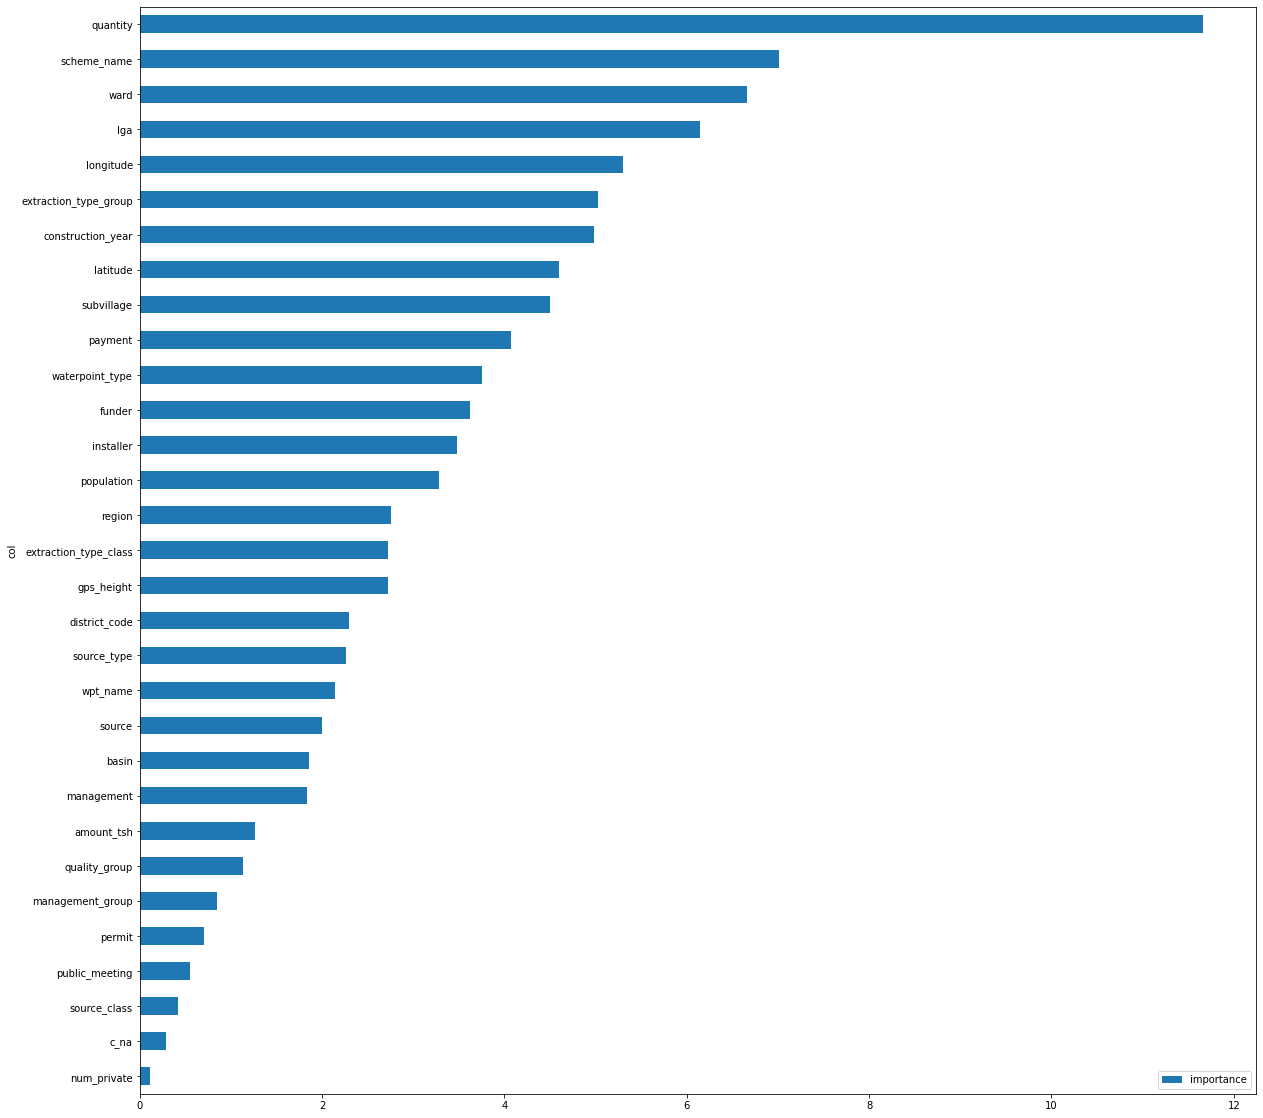

In [29]:
m = models[(SEEDS[0],0)]
fea_imp = pd.DataFrame({'importance': m.feature_importances_,
                        'col': m.feature_names_})
fea_imp = fea_imp.sort_values(['importance', 'col'],
                               ascending=[True, False]).iloc[-40:]
fea_imp.plot(kind='barh', x='col', y='importance', figsize=(20, 20))

In [32]:
y_pred_train = np.array([models[(SEEDS[0],0)].classes_[x] for x in oof_train.argmax(axis=1)])
print(f"balanced accuracy: {balanced_accuracy_score(y_train, y_pred_train)}")
class_rate = classification_rate(y_train, y_pred_train)
print(f"classification rate: {class_rate}")

balanced accuracy: 0.6543577509239386
classification rate: 0.8102693602693603


In [25]:
y_pred = np.array([models[(SEEDS[0],0)].classes_[x] for x in oof_test.argmax(axis=1)])
sub = pd.read_csv("data/SubmissionFormat.csv", index_col='id')
sub['status_group'] = y_pred
sub.to_csv(f"submissions/submission_catboost_{round(class_rate, 4)}.csv", index=True)